Data Preparation

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
# publications_df = pd.read_csv("/content/drive/MyDrive/Python_Final/DSM.csv", delimiter =",", encoding = 'utf-8')
# publications_df

In [ ]:
!pip install PyMuPDF #PyMuPDF library to read pdf
import io
import os
import fitz

In [ ]:
def scrape_article(URL):
    response = requests.get(URL)
    content_type = response.headers.get('Type', '').lower()
    if 'pdf' in content_type:
        with io.BytesIO(response.content) as f:
            doc = fitz.open(stream=f, filetype="pdf")
            pdf_text = ""
            for page in doc:
                pdf_text += page.get_text()
            return pdf_text
    else:
        response.encoding = 'utf-8'
        html_string = response.text
        soup = BeautifulSoup(html_string, 'html.parser')
        return soup.get_text()

Because there are several website returned 403 Forbidena and unreadable files. I mannually cleaned the csv up and added articles that are inretrievable.


In [ ]:
publications_cleaned_df = pd.read_csv("/content/drive/MyDrive/Python_Final/yimings/DSM_New.csv", delimiter =",", encoding = 'utf-8')
publications_cleaned_df


Clean the Data

In [ ]:
publications_cleaned_df['text'] =publications_cleaned_df['text'].map(str).apply(lambda x: x.encode('utf-8').decode('ascii', 'ignore'))
publications_cleaned_df['text'] = publications_cleaned_df['text'].str.replace('\n', ' ')
publications_cleaned_df

In [ ]:
publications_cleaned_df['Date'] = pd.to_datetime(publications_cleaned_df['Date'], format = '%d-%b')

In [ ]:
# publications_cleaned_df['date'] = pd.to_datetime(publications_cleaned_df['date'], format = '%m/%d/%y')

In [ ]:
publications_cleaned_df.dtypes

Date              datetime64[ns]
Publisher                 object
Type                      object
Title                     object
Primary Author            object
URL                       object
text                      object
dtype: object

## Group and exploring the data

In [ ]:
grouped_df = publications_cleaned_df.groupby(['Publisher', 'Type'])['text'].apply(' '.join).reset_index()
grouped_df = grouped_df.sort_values(by='Type', ascending=False)
grouped_df

## Exploring  Data

In [ ]:
author_counts = publications_cleaned_df.groupby(['Primary Author', 'Publisher']).size().reset_index(name='count')
author_counts = author_counts.sort_values(by='count', ascending=False)

author_counts


In [ ]:
counts = publications_cleaned_df.groupby(['Publisher', 'Type']).size().reset_index(name='count')
counts

## Number of Publications Across Time

<Axes: title={'center': 'Number of Publications by Month'}, xlabel='Date', ylabel='Value'>

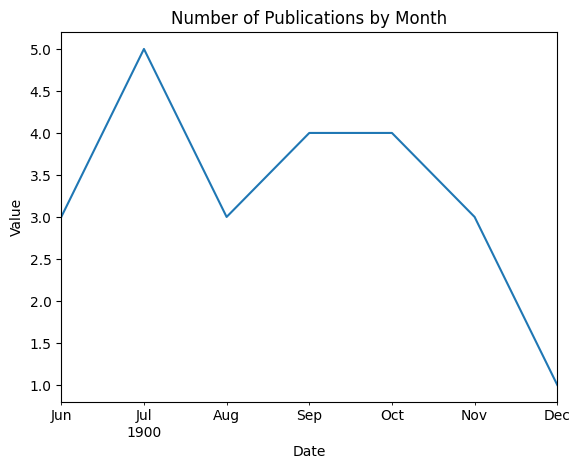

In [ ]:
#setting index as date so we can plot the data

linegraph = publications_cleaned_df.set_index('Date').groupby(pd.Grouper(freq='M')).size()

# adapted from here: https://stackoverflow.com/questions/26646191/pandas-groupby-month-and-year
linegraph.plot(kind='line', title='Number of Publications by Month', xlabel='Date', ylabel='Value')

# DATA Analysis

## Word Clouds, Lexical Densities

In [ ]:
# importing necessary libraries
# !pip install wordcloud
import nltk
from nltk.corpus import stopwords

from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import glob

In [ ]:
for i, row in grouped_df.iterrows():

    soup = BeautifulSoup(row['text'])
    article = soup.get_text()

    publication = row['Publisher']
    doc_type = row['Type']


    # Use f-strings to create the file name
    file_name = f"/content/drive/MyDrive/Python_Final/yimings/files/{publication}_{doc_type}s.txt"

    with open(file_name, "w") as file:
        file.write(article)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stops = stopwords.words('english') #importing nltk's English stopwords
directory = '/content/drive/MyDrive/Python_Final/yimings/files'
files = glob.glob(f"{directory}/*.txt")

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

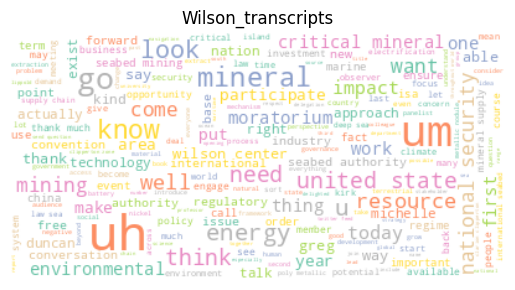

0.3409578270192995


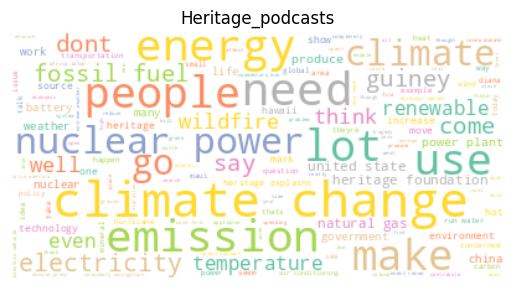

0.43048694424841216


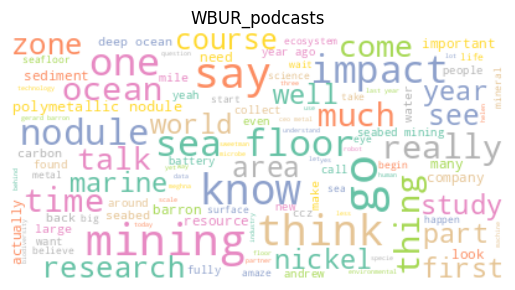

0.38744672607516467


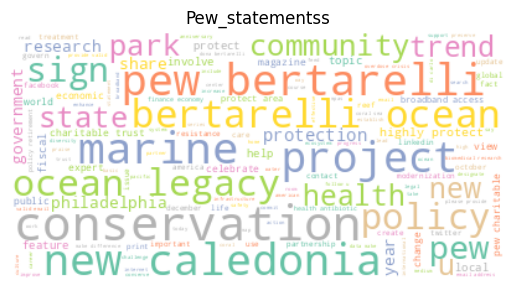

0.3633610900832703


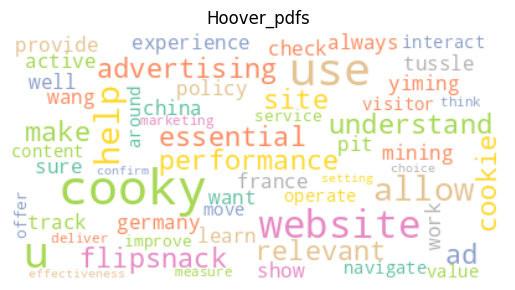

0.6477272727272727


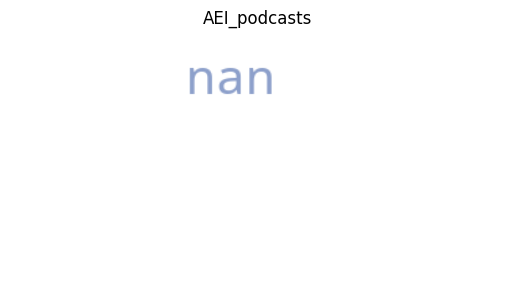

1.0


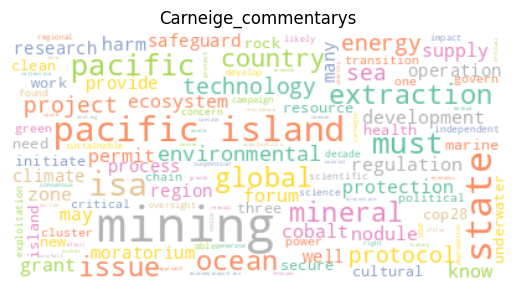

0.6206896551724138


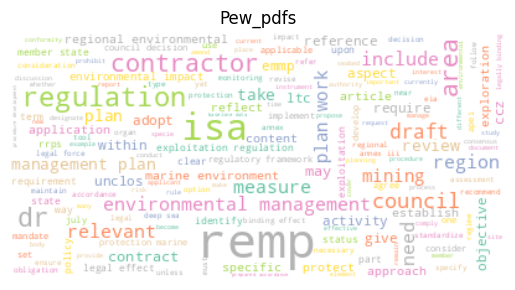

0.3335256780150029


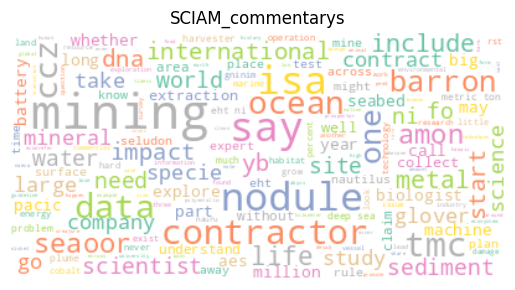

0.5098360655737705


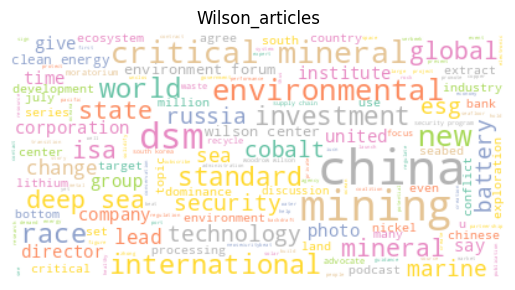

0.5808550185873605


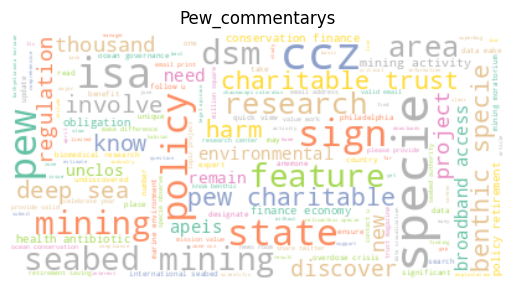

0.25353706847764573


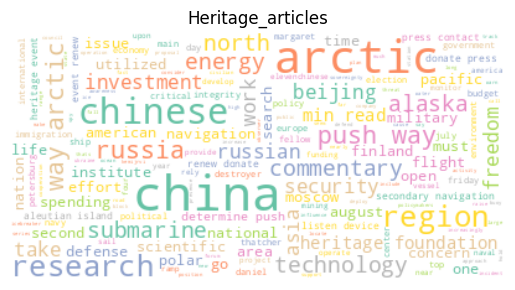

0.6069114470842333


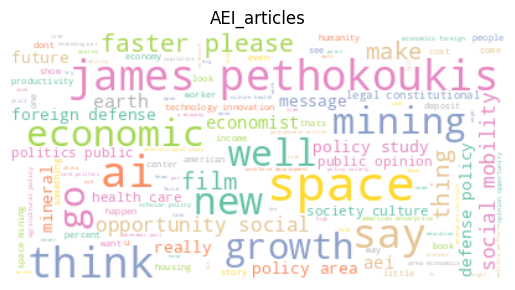

0.38205499276411


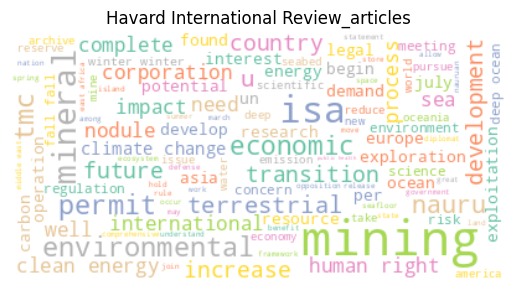

0.5515548281505729


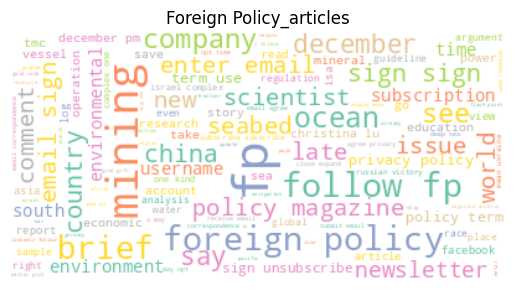

0.3948849104859335


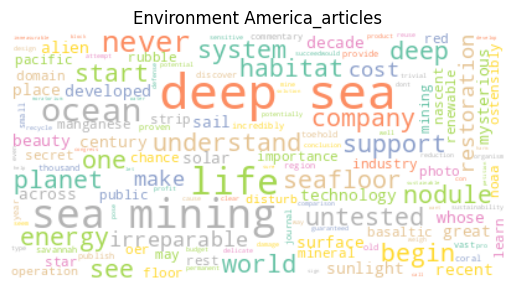

0.7128205128205128


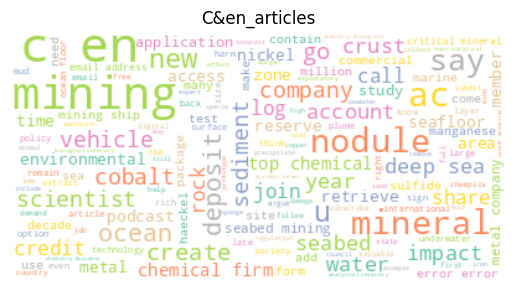

0.390198279087168


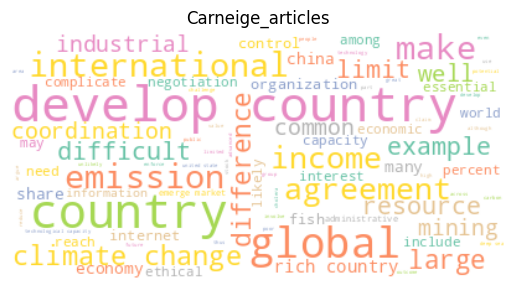

0.5344168260038241


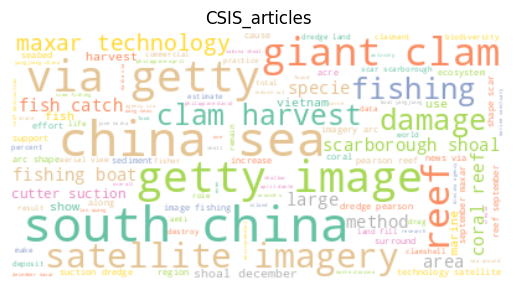

0.24624240486088902


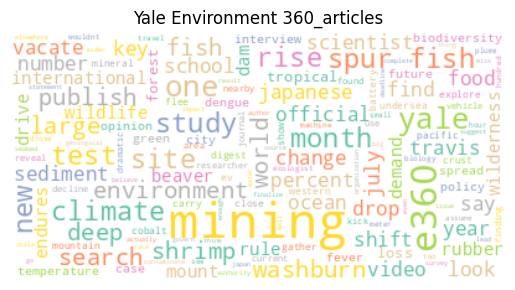

0.6545961002785515


In [ ]:

# this function was taken from lecture
id = 0
lexical_density = []
for filepath in files:
    text = open(filepath, encoding='utf-8').read()
    text_tokens = nltk.word_tokenize(text)
    nltk_text = nltk.Text(text_tokens)
    text_lower = [t.lower() for t in nltk_text if t.isalnum()]
    text_stops = [t for t in text_lower if t not in stops]
    text_clean = [WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in text_stops]

# save cleaned files
    file_name = filepath.split("/")[-1]
    file_name = file_name.split(".")[0]
    with open(f"/content/drive/MyDrive/Python_Final/yimings/files_cleaned/{file_name}.txt", "w") as file:
        file.write(str(text_clean))

# create Word Clouds

    unique_string=(" ").join(text_clean)
    wordcloud = WordCloud(max_font_size=40, background_color='white', colormap='Set2').generate(unique_string)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(file_name)
    plt.show()

# save Word Clouds
    wordcloud.to_file(f"/content/drive/MyDrive/Python_Final/yimings/wordclouds/wordcloud_{file_name}.png")

# lexical density
    ld_results = len(set(text_clean)) / len(text_clean) # unlike the lecture, I want to analyze the whole text, not just a slice
    print(ld_results)
    ld_dict = {'File_name': file_name, 'lexical_density': ld_results}
    lexical_density.append(ld_dict)

### Adding Stop Words

In [ ]:
# To add author names to stop words, I first pulled the names from the author 1 and author 2 columns and separated the first and last names so each name would be its own string


author_list = []

# for author in publications_cleaned_df['Primary Author']:
#     print(type(author))
#     first_name, last_name = author.split(' ', 1)
#     if first_name.lower() not in author_list and last_name.lower() not in author_list: # this ensures each author is only added once
#         author_list.append(first_name.lower())
#         author_list.append(last_name.lower())

for author in publications_cleaned_df['Primary Author']:
    if pd.isnull(author):
        continue
    else:
        first_name, last_name = author.split(' ', 1)
        if first_name.lower() not in author_list and last_name.lower() not in author_list:
            author_list.append(first_name.lower())
            author_list.append(last_name.lower())


In [ ]:
# i created my own for/if loop, but adapted a name splitter from this: https://stackoverflow.com/questions/57463127/splitting-a-column-in-dataframe-using-str-split-function
stops = stopwords.words('english')

new_stopwords = ["brookings", "institute", "institution", "policy", "center", "facebook", "heritage", "urban", "aei",
                 "enterprise", "program", "news", "program", "benefits", "benefit", "snap", "percent", "programs"]
stops.extend(new_stopwords)
stops.extend(author_list) # i used extend instead of append to add multiple items, used this as reference: https://www.freecodecamp.org/news/python-list-append-vs-python-list-extend/

### Running the word and lexical densities with the new stop words

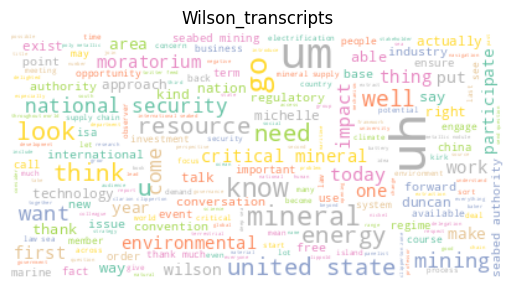

0.34310532030401736


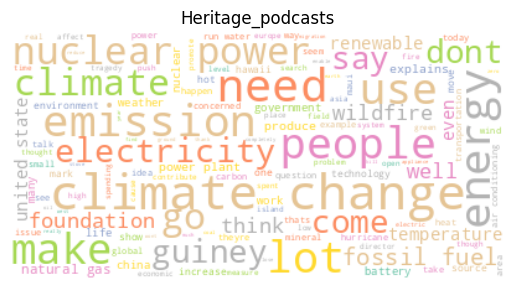

0.4357864357864358


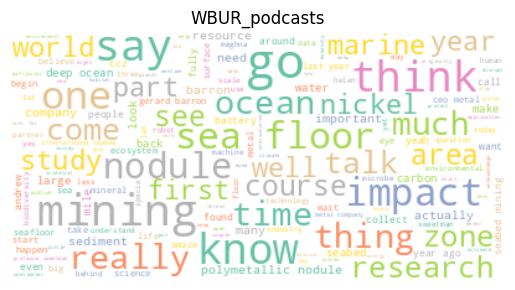

0.38739789964994165


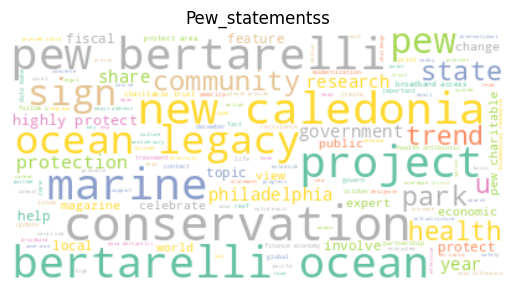

0.36752136752136755


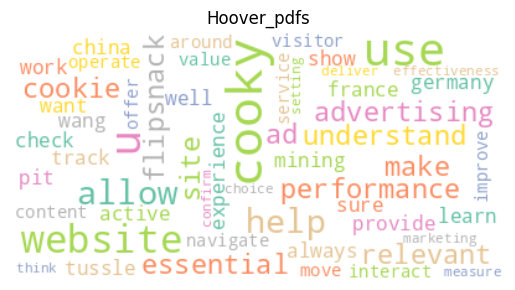

0.6395348837209303


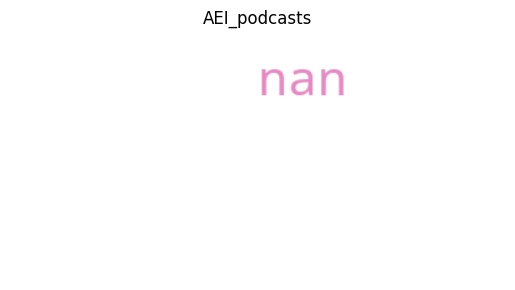

1.0


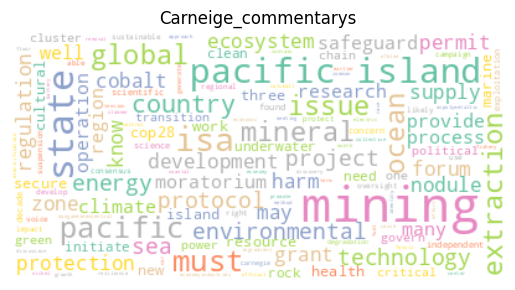

0.6193771626297578


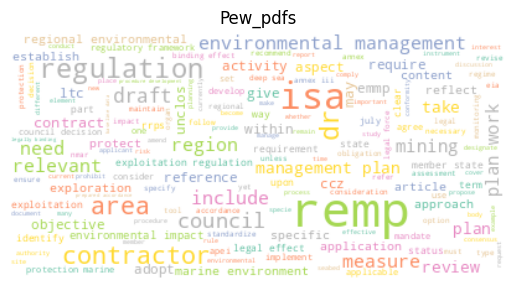

0.3342972816657027


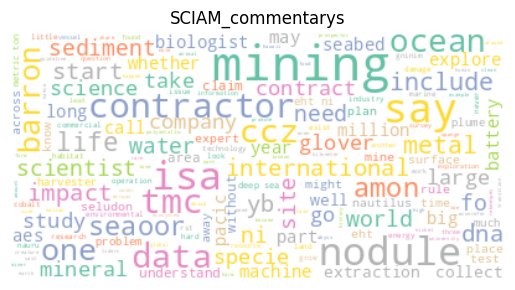

0.5100781571369807


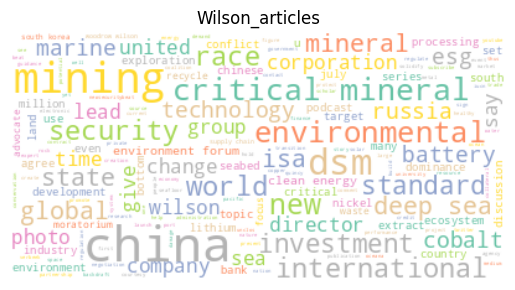

0.5844402277039848


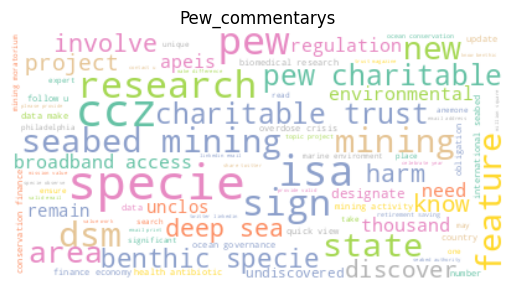

0.25600231414521263


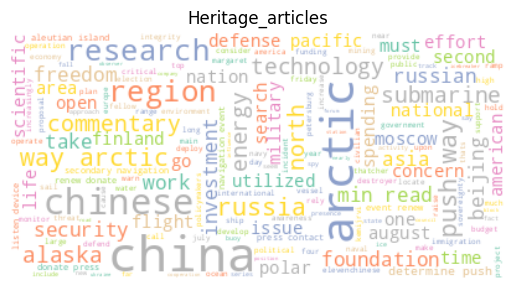

0.6120879120879121


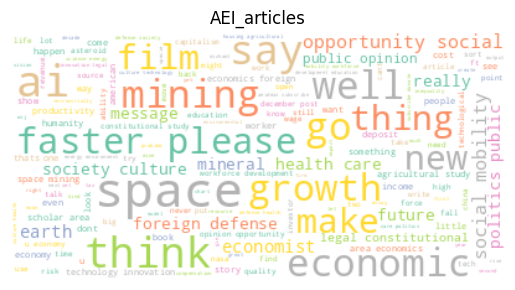

0.3927409261576971


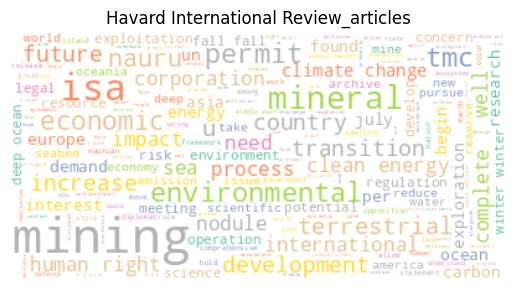

0.5520661157024793


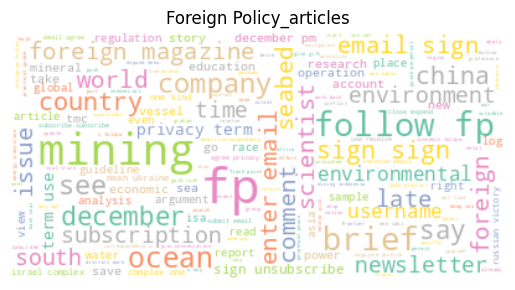

0.4003147953830011


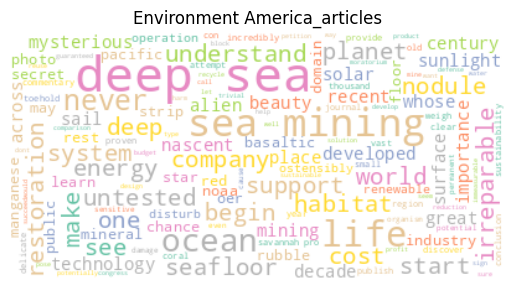

0.7128205128205128


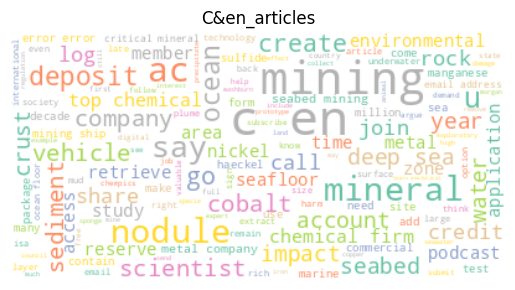

0.3915343915343915


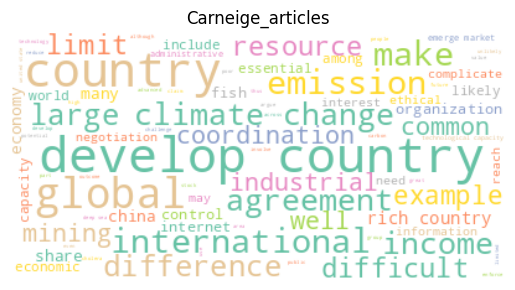

0.5346820809248555


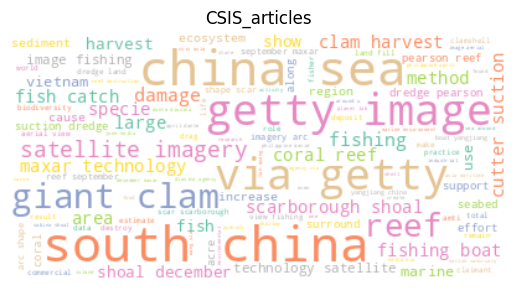

0.24613402061855671


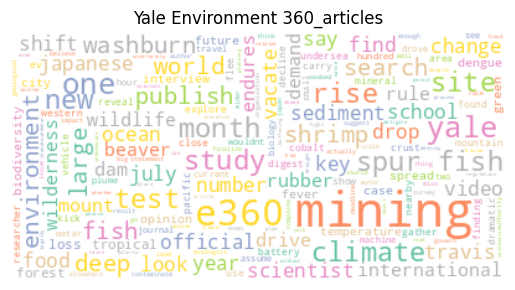

0.655367231638418


In [ ]:
id = 0
lexical_density_clean = []
for filepath in files:
    text = open(filepath, encoding='utf-8').read()
    text_tokens = nltk.word_tokenize(text)
    nltk_text = nltk.Text(text_tokens)
    text_lower = [t.lower() for t in nltk_text if t.isalnum()]
    text_stops = [t for t in text_lower if t not in stops]
    text_clean = [WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in text_stops]

# save cleaned files
    file_name = filepath.split("/")[-1]
    file_name = file_name.split(".")[0]
    with open(f"/content/drive/MyDrive/Python_Final/yimings/files_cleaned/{file_name}.txt", "w") as file:
        file.write(str(text_clean))

# create Word Clouds

    unique_string=(" ").join(text_clean)
    wordcloud = WordCloud(max_font_size=40, background_color='white', colormap='Set2').generate(unique_string)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(file_name)
    plt.show()

# save Word Clouds
    wordcloud.to_file(f"/content/drive/MyDrive/Python_Final/yimings/wordclouds_clean/wordcloud_{file_name}.png")

# lexical density
    ld_results = len(set(text_clean)) / len(text_clean) # unlike the lecture, I want to analyze the whole text, not just a slice
    print(ld_results)
    ld_dict = {'File_name': file_name, 'lexical_density': ld_results}
    lexical_density_clean.append(ld_dict)

### Lexical Densities

In [ ]:
lexical_density

[{'File_name': 'Wilson_transcripts', 'lexical_density': 0.3409578270192995},
 {'File_name': 'Heritage_podcasts', 'lexical_density': 0.43048694424841216},
 {'File_name': 'WBUR_podcasts', 'lexical_density': 0.38744672607516467},
 {'File_name': 'Pew_statementss', 'lexical_density': 0.3633610900832703},
 {'File_name': 'Hoover_pdfs', 'lexical_density': 0.6477272727272727},
 {'File_name': 'AEI_podcasts', 'lexical_density': 1.0},
 {'File_name': 'Carneige_commentarys', 'lexical_density': 0.6206896551724138},
 {'File_name': 'Pew_pdfs', 'lexical_density': 0.3335256780150029},
 {'File_name': 'SCIAM_commentarys', 'lexical_density': 0.5098360655737705},
 {'File_name': 'Wilson_articles', 'lexical_density': 0.5808550185873605},
 {'File_name': 'Pew_commentarys', 'lexical_density': 0.25353706847764573},
 {'File_name': 'Heritage_articles', 'lexical_density': 0.6069114470842333},
 {'File_name': 'AEI_articles', 'lexical_density': 0.38205499276411},
 {'File_name': 'Havard International Review_articles',
  

In [ ]:
lexicaldensity_df = pd.DataFrame(lexical_density)
lexicaldensity_df = lexicaldensity_df.sort_values(by='lexical_density', ascending=False)
lexicaldensity_df

### Lexical Densities by Same Publication Type

In [ ]:
oped_lexical = lexicaldensity_df[lexicaldensity_df['File_name'].str.contains('podcasts')]
oped_lexical

File_name  lexical_density
5       AEI_podcasts         1.000000
1  Heritage_podcasts         0.430487
2      WBUR_podcasts         0.387447

In [ ]:
reports_lexical = lexicaldensity_df[lexicaldensity_df['File_name'].str.contains('articles')]
reports_lexical

File_name  lexical_density
15          Environment America_articles         0.712821
19         Yale Environment 360_articles         0.654596
11                     Heritage_articles         0.606911
9                        Wilson_articles         0.580855
13  Havard International Review_articles         0.551555
17                     Carneige_articles         0.534417
14               Foreign Policy_articles         0.394885
16                         C&en_articles         0.390198
12                          AEI_articles         0.382055
18                         CSIS_articles         0.246242

In [ ]:
reports_lexical = lexicaldensity_df[lexicaldensity_df['File_name'].str.contains('commentarys')]
reports_lexical

File_name  lexical_density
6   Carneige_commentarys         0.620690
8      SCIAM_commentarys         0.509836
10       Pew_commentarys         0.253537

In [ ]:
reports_lexical = lexicaldensity_df[lexicaldensity_df['File_name'].str.contains('statementss')]
reports_lexical

File_name  lexical_density
3  Pew_statementss         0.363361

In [ ]:
reports_lexical = lexicaldensity_df[lexicaldensity_df['File_name'].str.contains('pdfs')]
reports_lexical

File_name  lexical_density
4  Hoover_pdfs         0.647727
7     Pew_pdfs         0.333526

In [ ]:
reports_lexical = lexicaldensity_df[lexicaldensity_df['File_name'].str.contains('transcripts')]
reports_lexical

File_name  lexical_density
0  Wilson_transcripts         0.340958

## TF-IDF

In [ ]:
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# initializing TfidVectorizer object
tfidf_vectorizer = TfidfVectorizer(input = 'filename', stop_words = stops)
type(tfidf_vectorizer)
text_titles = [Path(text).stem for text in files]
text_titles

['Wilson_transcripts',
 'Heritage_podcasts',
 'WBUR_podcasts',
 'Pew_statementss',
 'Hoover_pdfs',
 'AEI_podcasts',
 'Carneige_commentarys',
 'Pew_pdfs',
 'SCIAM_commentarys',
 'Wilson_articles',
 'Pew_commentarys',
 'Heritage_articles',
 'AEI_articles',
 'Havard International Review_articles',
 'Foreign Policy_articles',
 'Environment America_articles',
 'C&en_articles',
 'Carneige_articles',
 'CSIS_articles',
 'Yale Environment 360_articles']

In [ ]:
# creating a dataframe of each term's tf-idf score for each file
tfidf_vector = tfidf_vectorizer.fit_transform(files)
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index = text_titles, columns = tfidf_vectorizer.get_feature_names_out()) #array format dataaset
tfidf_df

In [ ]:
tfidf_df.to_csv('/content/drive/MyDrive/Python_Final/yimings/tfidf_df.csv')
# exported this to csv to view all of the terms, using this csv I pulled some terms that I was interested in investigating


In [ ]:
# pulling words that I'm interested in !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

tfidf_slice = tfidf_df[['dependence', 'dependent', 'biden', 'spending', 'work',  'family', 'children', 'reduce']]
tfidf_slice.sort_index().round(decimals = 2)

dependence  dependent  biden  spending  \
AEI_articles                                0.00       0.00   0.02      0.00   
AEI_podcasts                                0.00       0.00   0.00      0.00   
C&en_articles                               0.00       0.00   0.00      0.00   
CSIS_articles                               0.01       0.00   0.00      0.00   
Carneige_articles                           0.00       0.00   0.00      0.00   
Carneige_commentarys                        0.00       0.03   0.00      0.00   
Environment America_articles                0.00       0.00   0.00      0.00   
Foreign Policy_articles                     0.00       0.00   0.04      0.00   
Havard International Review_articles        0.00       0.00   0.00      0.00   
Heritage_articles                           0.00       0.00   0.02      0.06   
Heritage_podcasts                           0.00       0.01   0.01      0.04   
Hoover_pdfs                                 0.00       0.00   0.00      0.00   
Pew_commentarys                             0.00       0.00   0.00      0.00   
Pew_pdfs                                    0.00       0.00   0.00      0.00   
Pew_statementss                             0.00       0.00   0.00      0.00   
SCIAM_commentarys                           0.00       0.00   0.00      0.00   
WBUR_podcasts                               0.00       0.01   0.00      0.00   
Wilson_articles                             0.00       0.00   0.02      0.02   
Wilson_transcripts                          0.01       0.00   0.00      0.00   
Yale Environment 360_articles               0.00       0.00   0.00      0.00   

                                      work  family  children  reduce  
AEI_articles                          0.02    0.01      0.00    0.00  
AEI_podcasts                          0.00    0.00      0.00    0.00  
C&en_articles                         0.00    0.00      0.00    0.01  
CSIS_articles                         0.00    0.00      0.00    0.00  
Carneige_articles                     0.00    0.00      0.00    0.01  
Carneige_commentarys                  0.02    0.00      0.00    0.00  
Environment America_articles          0.00    0.00      0.00    0.00  
Foreign Policy_articles               0.03    0.00      0.00    0.01  
Havard International Review_articles  0.00    0.00      0.00    0.03  
Heritage_articles                     0.02    0.02      0.00    0.00  
Heritage_podcasts                     0.05    0.01      0.00    0.01  
Hoover_pdfs                           0.04    0.00      0.00    0.00  
Pew_commentarys                       0.04    0.02      0.00    0.00  
Pew_pdfs                              0.05    0.00      0.00    0.00  
Pew_statementss                       0.04    0.02      0.00    0.00  
SCIAM_commentarys                     0.01    0.00      0.00    0.00  
WBUR_podcasts                         0.00    0.00      0.03    0.02  
Wilson_articles                       0.00    0.00      0.00    0.00  
Wilson_transcripts                    0.02    0.00      0.00    0.00  
Yale Environment 360_articles         0.00    0.00      0.00    0.00

In [ ]:
# this is creating a row for each term for document tuype
tfidf_df_long = tfidf_df.stack().reset_index()
tfidf_df_long = tfidf_df_long.rename(columns={0:'tfidf', 'level_0': 'document type','level_1': 'term'})
tfidf_df_long

document type        term  tfidf
0                  Wilson_transcripts          00    0.0
1                  Wilson_transcripts         000    0.0
2                  Wilson_transcripts       00010    0.0
3                  Wilson_transcripts       00080    0.0
4                  Wilson_transcripts        0009    0.0
...                               ...         ...    ...
138195  Yale Environment 360_articles        zhao    0.0
138196  Yale Environment 360_articles        zinc    0.0
138197  Yale Environment 360_articles        zone    0.0
138198  Yale Environment 360_articles       zones    0.0
138199  Yale Environment 360_articles  zonesocean    0.0

[138200 rows x 3 columns]

In [ ]:
# pulling the top 10 tf-idf's for each document type
top_tfidf = tfidf_df_long.sort_values(by = ['document type', 'tfidf'], ascending = [True, False]).groupby(['document type']).head(10)
top_tfidf

### Comparing Top TF-IDF Values for procasts

In [ ]:
top_tfidf[top_tfidf['document type'] == 'Heritage_podcasts']

In [ ]:
top_tfidf[top_tfidf['document type'] == 'WBUR_podcasts']

### Comparing Top TF-IDF Values for articals

In [ ]:
top_tfidf[top_tfidf['document type'] == 'Environment America_articles']

In [ ]:
top_tfidf[top_tfidf['document type'] == 'Yale Environment 360_articles']

In [ ]:
top_tfidf[top_tfidf['document type'] == 'Havard International Review_articles']

In [ ]:
top_tfidf[top_tfidf['document type'] == 'Foreign Policy_articles']

## Sentiment Analysis

In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentimentAnalyzer = SentimentIntensityAnalyzer()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.4 MB/s eta 0:00:00


In [ ]:
def compound_sentiment(text):
    scores = sentimentAnalyzer.polarity_scores(text)
    compound_scores = scores['compound'] #using compound scores
    return compound_scores
grouped_df['compound_score'] = grouped_df['text'].apply(compound_sentiment)
grouped_df

Publisher        Type  \
18                       Wilson  transcript   
14                          Pew  statements   
10                     Heritage     podcast   
16                         WBUR     podcast   
1                           AEI     podcast   
11                       Hoover         pdf   
13                          Pew         pdf   
5                      Carneige  commentary   
15                        SCIAM  commentary   
12                          Pew  commentary   
17                       Wilson     article   
0                           AEI     article   
9                      Heritage     article   
8   Havard International Review     article   
7                Foreign Policy     article   
6           Environment America     article   
4                      Carneige     article   
3                          CSIS     article   
2                          C&en     article   
19         Yale Environment 360     article   

                                                 text  compound_score  
18  good afternoon everybody thank you so much for...          1.0000  
14  Pew Bertarelli Ocean Legacy Praises New Caledo...          0.9993  
10  What Do Wildfires and Hurricanes Say About Cli...          0.2781  
16  Deep-sea mining: Climate solution or ecologica...          0.9999  
1                                                 nan          0.0000  
11  Deep-sea mining tussle pits France and Germany...          0.9738  
13  This discussion paper has been developed by th...          0.9995  
5   As COP28 approaches, Pacific Island officials ...          0.9931  
15  Mining the seaoor could boost global productio...          0.9980  
12  Seabed Mining Moratorium Is Legally Required b...          0.9999  
17   China Leads the Race to the Bottom: Deep Sea ...          0.9954  
0   A Few Quick Questions for  Economist Ian Lange...          1.0000  
9   China Is Determined To Push Its Way Into the A...          0.9965  
8   Deep Sea Mining and the Green Transition US Eu...          0.9979  
7   Deep-Sea Mining: Will ISA Regulatory Deadline ...          0.9964  
6   The deep sea is one of the most mysterious pla...          0.9656  
4   Over the next few decades, emerging markets wi...          0.9988  
3   Deep Blue Scars: Environmental Threats to the ...         -0.9992  
2   The deep-sea mining dilemma Advertisement ACS ...          0.9995  
19  Deep-Sea Mining Spurs Fish to Vacate Mining Si...         -0.2598

In [ ]:
def positive_sentiment(text):
    scores = sentimentAnalyzer.polarity_scores(text)
    positive_scores = scores['pos'] #using compound scores
    return positive_scores
# this function was taken from lecture
def negative_sentiment(text):
    scores = sentimentAnalyzer.polarity_scores(text)
    negative_scores = scores['neg'] #using compound scores
    return negative_scores
grouped_df['positive_score'] = grouped_df['text'].apply(positive_sentiment)
grouped_df['negative_score'] = grouped_df['text'].apply(negative_sentiment)

In [ ]:
grouped_df = grouped_df.sort_values(by='positive_score', ascending=False)
grouped_df

Publisher        Type  \
11                       Hoover         pdf   
0                           AEI     article   
4                      Carneige     article   
18                       Wilson  transcript   
12                          Pew  commentary   
14                          Pew  statements   
8   Havard International Review     article   
5                      Carneige  commentary   
6           Environment America     article   
2                          C&en     article   
17                       Wilson     article   
9                      Heritage     article   
10                     Heritage     podcast   
16                         WBUR     podcast   
13                          Pew         pdf   
7                Foreign Policy     article   
15                        SCIAM  commentary   
19         Yale Environment 360     article   
3                          CSIS     article   
1                           AEI     podcast   

                                                 text  compound_score  \
11  Deep-sea mining tussle pits France and Germany...          0.9738   
0   A Few Quick Questions for  Economist Ian Lange...          1.0000   
4   Over the next few decades, emerging markets wi...          0.9988   
18  good afternoon everybody thank you so much for...          1.0000   
12  Seabed Mining Moratorium Is Legally Required b...          0.9999   
14  Pew Bertarelli Ocean Legacy Praises New Caledo...          0.9993   
8   Deep Sea Mining and the Green Transition US Eu...          0.9979   
5   As COP28 approaches, Pacific Island officials ...          0.9931   
6   The deep sea is one of the most mysterious pla...          0.9656   
2   The deep-sea mining dilemma Advertisement ACS ...          0.9995   
17   China Leads the Race to the Bottom: Deep Sea ...          0.9954   
9   China Is Determined To Push Its Way Into the A...          0.9965   
10  What Do Wildfires and Hurricanes Say About Cli...          0.2781   
16  Deep-sea mining: Climate solution or ecologica...          0.9999   
13  This discussion paper has been developed by th...          0.9995   
7   Deep-Sea Mining: Will ISA Regulatory Deadline ...          0.9964   
15  Mining the seaoor could boost global productio...          0.9980   
19  Deep-Sea Mining Spurs Fish to Vacate Mining Si...         -0.2598   
3   Deep Blue Scars: Environmental Threats to the ...         -0.9992   
1                                                 nan          0.0000   

    positive_score  negative_score  
11           0.166           0.000  
0            0.148           0.060  
4            0.142           0.085  
18           0.133           0.034  
12           0.130           0.048  
14           0.126           0.018  
8            0.122           0.073  
5            0.113           0.065  
6            0.109           0.048  
2            0.107           0.059  
17           0.091           0.047  
9            0.085           0.037  
10           0.085           0.075  
16           0.084           0.023  
13           0.078           0.020  
7            0.075           0.051  
15           0.072           0.050  
19           0.048           0.047  
3            0.045           0.066  
1            0.000           0.000

In [ ]:
grouped_df = grouped_df.sort_values(by='negative_score', ascending=False)
grouped_df

Publisher        Type  \
4                      Carneige     article   
10                     Heritage     podcast   
8   Havard International Review     article   
3                          CSIS     article   
5                      Carneige  commentary   
0                           AEI     article   
2                          C&en     article   
7                Foreign Policy     article   
15                        SCIAM  commentary   
12                          Pew  commentary   
6           Environment America     article   
17                       Wilson     article   
19         Yale Environment 360     article   
9                      Heritage     article   
18                       Wilson  transcript   
16                         WBUR     podcast   
13                          Pew         pdf   
14                          Pew  statements   
11                       Hoover         pdf   
1                           AEI     podcast   

                                                 text  compound_score  \
4   Over the next few decades, emerging markets wi...          0.9988   
10  What Do Wildfires and Hurricanes Say About Cli...          0.2781   
8   Deep Sea Mining and the Green Transition US Eu...          0.9979   
3   Deep Blue Scars: Environmental Threats to the ...         -0.9992   
5   As COP28 approaches, Pacific Island officials ...          0.9931   
0   A Few Quick Questions for  Economist Ian Lange...          1.0000   
2   The deep-sea mining dilemma Advertisement ACS ...          0.9995   
7   Deep-Sea Mining: Will ISA Regulatory Deadline ...          0.9964   
15  Mining the seaoor could boost global productio...          0.9980   
12  Seabed Mining Moratorium Is Legally Required b...          0.9999   
6   The deep sea is one of the most mysterious pla...          0.9656   
17   China Leads the Race to the Bottom: Deep Sea ...          0.9954   
19  Deep-Sea Mining Spurs Fish to Vacate Mining Si...         -0.2598   
9   China Is Determined To Push Its Way Into the A...          0.9965   
18  good afternoon everybody thank you so much for...          1.0000   
16  Deep-sea mining: Climate solution or ecologica...          0.9999   
13  This discussion paper has been developed by th...          0.9995   
14  Pew Bertarelli Ocean Legacy Praises New Caledo...          0.9993   
11  Deep-sea mining tussle pits France and Germany...          0.9738   
1                                                 nan          0.0000   

    positive_score  negative_score  
4            0.142           0.085  
10           0.085           0.075  
8            0.122           0.073  
3            0.045           0.066  
5            0.113           0.065  
0            0.148           0.060  
2            0.107           0.059  
7            0.075           0.051  
15           0.072           0.050  
12           0.130           0.048  
6            0.109           0.048  
17           0.091           0.047  
19           0.048           0.047  
9            0.085           0.037  
18           0.133           0.034  
16           0.084           0.023  
13           0.078           0.020  
14           0.126           0.018  
11           0.166           0.000  
1            0.000           0.000

### Using Flair Instead of VADER

In [ ]:
# !pip install flair
# import flair
# from flair.models import TextClassifier
# from flair.data import Sentence
# classifier = TextClassifier.load('en-sentiment')
# def flair_sentiment(text, column_name):
#     sentence = Sentence(text)
#     classifier.predict(sentence)
#     return sentence.labels[0].score

# grouped_df['flair_score'] = grouped_df['text'].apply(flair_sentiment, column_name='text')

# #adapted from:  https://towardsdatascience.com/text-classification-with-state-of-the-art-nlp-library-flair-b541d7add21f
# grouped_df

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 60.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2

ModuleNotFoundError: ignored